<a href="https://colab.research.google.com/github/snsamarasekara/Portfolio_Projects/blob/main/Medicare_fraud_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy
import os 

import matplotlib.pyplot as plt

# libraries for modeling

from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
import random

from scipy.stats import ttest_ind

In [ ]:
df_2019 = pd.read_csv('https://raw.githubusercontent.com/snsamarasekara/Data2/main/fraud%20data.txt',encoding = "ISO-8859-1",low_memory=False) 

In [ ]:
df_2019.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
0,1144645441,Nurse Practitioner,KY,F,15,106.0,69,504.0,315,1.5928,103833.0,25026.71,2016,0
1,1215036645,General Surgery,TN,M,35,42.0,68,128.0,69,1.9847,176562.4,34067.57,2017,0
2,1598203416,Certified Registered Nurse Anesthetist (CRNA),FL,M,15,82.0,73,23.0,21,4.9356,35451.0,5020.17,2018,0
3,1386608115,Dermatology,NC,F,32,385.0,74,4810.0,1146,0.7887,630920.0,214255.90,2018,0
4,1497773790,Optometry,MA,M,8,62.0,71,153.0,140,0.9155,21300.0,13016.19,2017,0


In [ ]:

df2 = pd.read_csv("https://raw.githubusercontent.com/snsamarasekara/Data2/main/fraud%20data.txt")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
droped_cols_leie = [col for col in df2.columns if col not in ['NPI','EXCLTYPE','EXCLDATE'
                                                                   ,'REINDATE', 'WAIVERDATE']]
df2.drop(droped_cols_leie, axis=1, inplace=True)
df2=df2[df2["NPI"]>0]

In [ ]:
df2.head()

,NPI,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE
1,1972902351,1128b8,20220320,0,0
4,1922348218,1128a1,20180419,0,0
24,1942476080,1128b8,20170518,0,0
28,1275600959,1128a1,20130320,0,0
31,1891731758,1128b8,20170518,0,0


In [ ]:
# cleaning and preprocessing data tables
df2.drop('REINDATE', axis=1, inplace=True)
df2.head()
df2['EXCLDATE_END']=0
df2.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
1,1972902351,1128b8,20220320,0,0
4,1922348218,1128a1,20180419,0,0
24,1942476080,1128b8,20170518,0,0
28,1275600959,1128a1,20130320,0,0
31,1891731758,1128b8,20170518,0,0


In [ ]:
df2=df2.reset_index()
df2.drop('index', axis=1, inplace=True)
df2.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
0,1972902351,1128b8,20220320,0,0
1,1922348218,1128a1,20180419,0,0
2,1942476080,1128b8,20170518,0,0
3,1275600959,1128a1,20130320,0,0
4,1891731758,1128b8,20170518,0,0


In [ ]:
for idx,date in enumerate(list(df2['EXCLDATE'])):
    dt=str(date)
    yr=dt[:4]
    if  df2.loc[idx,"EXCLTYPE"] in ['1128a1',"1128a2","1128a3"]:
        exc_year=int(yr)+5
        df2.loc[idx,"EXCLDATE_END"]=str(exc_year)+dt[4:6]
df2[df2['WAIVERDATE']> 0]


,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
386,1093935355,1128b8,20090618,20090618,0
686,1871571406,1128a1,20160120,20160218,202101
3418,1205832227,1128a1,20100920,20140917,201509
3952,1285673012,1128a1,20150618,20150618,202006
4444,1114922606,1128a1,20110720,20110720,0
4543,1033186697,1128a4,20110920,20111115,0
5234,1427028638,1128a1,20120220,20120220,0


In [ ]:
# text to numeric
df2["EXCLDATE"] = pd.to_numeric(df2["EXCLDATE"])
df2["WAIVERDATE"] = pd.to_numeric(df2["WAIVERDATE"])
df2["EXCLDATE_END"] = pd.to_numeric(df2["EXCLDATE_END"])
df2[df2['WAIVERDATE']> 0]


,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
386,1093935355,1128b8,20090618,20090618,0
686,1871571406,1128a1,20160120,20160218,202101
3418,1205832227,1128a1,20100920,20140917,201509
3952,1285673012,1128a1,20150618,20150618,202006
4444,1114922606,1128a1,20110720,20110720,0
4543,1033186697,1128a4,20110920,20111115,0
5234,1427028638,1128a1,20120220,20120220,0


In [ ]:
df2['Final_date']=df2['EXCLDATE_END']
for idx,date in enumerate(list(df2['WAIVERDATE'])):
    if df2.loc[idx,"WAIVERDATE"] > 0 :
        df2.loc[idx,"Final_date"]=df2.loc[idx,"WAIVERDATE"]
df2[df2['WAIVERDATE'] > 0]

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END,Final_date
386,1093935355,1128b8,20090618,20090618,0,20090618
686,1871571406,1128a1,20160120,20160218,202101,20160218
3418,1205832227,1128a1,20100920,20140917,201509,20140917
3952,1285673012,1128a1,20150618,20150618,202006,20150618
4444,1114922606,1128a1,20110720,20110720,0,20110720
4543,1033186697,1128a4,20110920,20111115,0,20111115
5234,1427028638,1128a1,20120220,20120220,0,20120220


In [ ]:
df2['Final_year']=0
df2=df2.reset_index()

for idx,date in enumerate(list(df2['Final_date'])):
    if df2.loc[idx,"Final_date"] > 0:
        dt=str(date)
        yr=dt[:4]
        mt=dt[4:]
        if (int(mt)>6):
            df2.loc[idx,"Final_year"] = int(yr)+1
        else :
            df2.loc[idx,"Final_year"] = int(yr)
df2=df2.reset_index()
df2.head()

,level_0,index,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END,Final_date,Final_year
0,0,0,1972902351,1128b8,20220320,0,0,0,0
1,1,1,1922348218,1128a1,20180419,0,202304,202304,2023
2,2,2,1942476080,1128b8,20170518,0,0,0,0
3,3,3,1275600959,1128a1,20130320,0,201803,201803,2018
4,4,4,1891731758,1128b8,20170518,0,0,0,0


In [ ]:
df2.drop('index', axis=1, inplace=True)
df2.drop('level_0', axis=1, inplace=True)
df2.head()
for idx,date in enumerate(list(df2['EXCLDATE'])):
    dt=str(date)
    yr=dt[:4]
    mt=dt[4:]
    df2.loc[idx,"EXCLDATE"] = int(yr)
    if df2.loc[idx,"Final_year"] == 0:
        if (int(mt)>6):
            df2.loc[idx,"Final_year"] = int(yr)+1
        else :
            df2.loc[idx,"Final_year"] = int(yr)
df2.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END,Final_date,Final_year
0,1972902351,1128b8,2022,0,0,0,2023
1,1922348218,1128a1,2018,0,202304,202304,2023
2,1942476080,1128b8,2017,0,0,0,2018
3,1275600959,1128a1,2013,0,201803,201803,2018
4,1891731758,1128b8,2017,0,0,0,2018


In [ ]:
#add fraud column
df_2019['Fraud']=0
# total frauds 
df=df_2019[df_2019['Rndrng_NPI'].isin(list(df2["NPI"]))]


In [ ]:
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
11223,1003000407,Family Practice,PA,M,23,64.0,79,476.0,160,2.1838,91196.00,37485.18,2018,0
11224,1003000407,Family Practice,PA,M,31,167.0,78,1637.0,401,2.0000,260033.00,136143.38,2016,0
11225,1003000407,Family Practice,PA,M,29,104.0,79,857.0,260,2.1173,132744.00,66084.78,2017,0
11226,1003066838,Family Practice,WY,M,48,33.0,67,414.0,83,1.3224,41931.00,10095.00,2019,0
11227,1003066838,Family Practice,WY,M,94,105.0,69,2979.0,242,1.1747,236078.97,70428.21,2018,0


In [ ]:
print('total frauds: ',df.shape[0]) # to check total number of frauds

total frauds:  1247


In [ ]:
# Exploratory data analysis
# fraud detection by medicare provider
#Split fraudulent and non-fraudulent providers :
df_neg=df[df['Fraud']==0]
df_pos=df[df['Fraud']==1]
sp=df_neg.sample(n=df_pos.shape[0]*9, random_state=1)

Text(0.5, 1.0, 'Gender (population)')

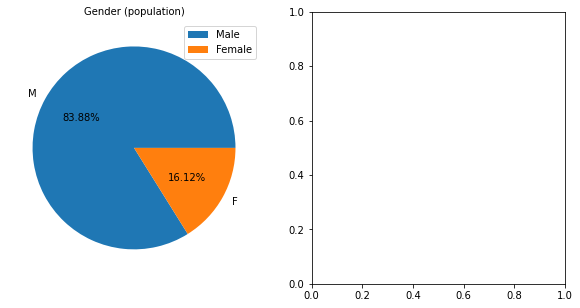

In [ ]:
# fraud rate by population (gender)
plt.rcParams["figure.figsize"] = (10,5)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax5 = df['Rndrng_Prvdr_Gndr'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "10" ,ax=axes[0],label='')
ax5.legend( labels=['Male','Female'], loc='best')
ax5.set_title(label='Gender (population)',fontsize=10)



#plt.show()

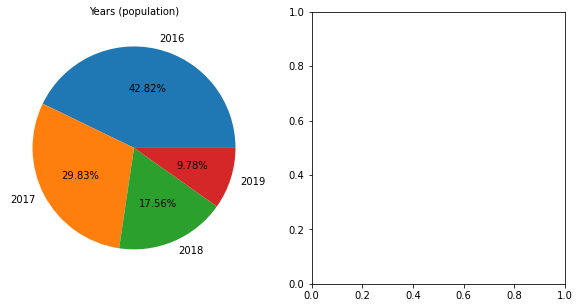

In [ ]:
# fraud by year 
plt.rcParams["figure.figsize"] = (10,5)
fig,axes = plt.subplots(nrows=1, ncols=2)

ax5 = df['year'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "10" ,ax=axes[0],label='')
ax5.set_title(label='Years (population)',fontsize=10)
plt.show()

In [ ]:
# common providers
print('Most common providers:')
display((df['Rndrng_Prvdr_Type'].value_counts()*100/df.shape[0]).to_frame().head(10))


Most common providers:


,Rndrng_Prvdr_Type
Internal Medicine,17.401764
Family Practice,15.477145
Nurse Practitioner,5.854050
Chiropractic,5.292702
Psychiatry,5.052125
Emergency Medicine,4.170008
Podiatry,4.009623
Anesthesiology,3.929431
Obstetrics & Gynecology,3.448276
Physical Medicine and Rehabilitation,3.127506


In [ ]:
# observations : Male practitioners showed a higher number of frauds
# number of frauds decrease over time
# Internal medicine has highest number of fraudulent providers


In [ ]:
# Data modeling 
# converting to numeric values
def convert_cat(df_cms):
    gender_map = {'M': 1,'F': 0}
    df=df()
    df['Rndrng_Prvdr_Gndr']=df['Rndrng_Prvdr_Gndr'].map(gender_map)
    df=pd.get_dummies(df)
    return df

In [ ]:
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
11223,1003000407,Family Practice,PA,M,23,64.0,79,476.0,160,2.1838,91196.00,37485.18,2018,0
11224,1003000407,Family Practice,PA,M,31,167.0,78,1637.0,401,2.0000,260033.00,136143.38,2016,0
11225,1003000407,Family Practice,PA,M,29,104.0,79,857.0,260,2.1173,132744.00,66084.78,2017,0
11226,1003066838,Family Practice,WY,M,48,33.0,67,414.0,83,1.3224,41931.00,10095.00,2019,0
11227,1003066838,Family Practice,WY,M,94,105.0,69,2979.0,242,1.1747,236078.97,70428.21,2018,0


In [ ]:
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from sklearn import svm
from collections import Counter
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay ,plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score ,roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.over_sampling import ADASYN 
from imblearn.ensemble import EasyEnsembleClassifier 
from sklearn.decomposition import PCA
import joblib

In [ ]:
#Train test split
X = df.drop(columns='Fraud')
y = df['Fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

In [ ]:
# random forrest
def Base_eval(model,X_train,y_train,rep):
    
    scores = { 'Recall': 'recall',
            'ROC_AUC': 'roc_auc',
            'Precision': 'precision',
            'F1_Score': 'f1'
            }

 
    scal = MinMaxScaler()


    if(type(model).__name__ in ['RandomForestClassifier']):

        steps = [('model', model)]
    else :
        steps = [('scal',scal),('model', model)]
    pipeline = Pipeline(steps=steps)

    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=rep, random_state=1)

    start = time.time()
    scores = cross_validate(model, X_train, y_train, scoring=scores, cv=cv)
    stop = time.time()

    return scores

In [ ]:
def grid_search(model,grid,X_train,y_train,method,minr,rep,score):

    #Sampling
    if(method=='rus'):
        samp = RandomUnderSampler(sampling_strategy=minr/(1-minr))
    elif(method=='ros'):
        samp = RandomOverSampler(sampling_strategy=minr/(1-minr))
    elif(method=='ros/rus'):
        over=RandomOverSampler(sampling_strategy=minr/(1-minr))
        under=RandomUnderSampler(sampling_strategy=1)
    elif(method=='smote'):
        samp=SMOTE()

    #Scaling 
    scal = StandardScaler()

    #define pipeline
    if(type(model).__name__ in ['RandomForestClassifier']):
        if(method=='ros/rus'):
            steps = [('over', over),('under',under) ,('model', model)]
        else:
            steps = [('samp', samp) ,('model', model)]
    else :
        steps = [('samp', samp) ,('scal',scal) ,('model', model)]

    pipeline = Pipeline(steps=steps)
    #rep x Stratified 5 folds
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=rep, random_state=1)

    #Evaluate :
    start = time.time()
    cv_grid = GridSearchCV(pipeline, param_grid = grid, scoring = score,cv=cv,verbose=1)
    cv_grid.fit(X_train,y_train)
    stop = time.time()

    if((stop - start)>=60):
        print(f"Grid serach time : {(stop - start)/60} min")
    else :
        print(f"Grid serach time : {(stop - start)} sec")

    return cv_grid


In [ ]:
def get_scores(scores_out):
    print('Precision :',round(np.mean(scores_out['test_Precision']),4),end=' | ')
    print('Recall :',round(np.mean(scores_out['test_Recall']),4),end=' | ')
    print('F1 Score :',round(np.mean(scores_out['test_F1_Score']),4),end=' | ')
    print('ROC_AUC :',round(np.mean(scores_out['test_ROC_AUC']),4))

In [ ]:
def sampling_eval(model,method,rep):
    prp_min=[0.2,0.3,0.4,0.5]
    for prp in prp_min :
        scores = Evaluate(model,X_train,y_train,rep,method,prp)
        print(method.upper() +' '+str(prp*100)+'/'+str((1-prp)*100) +' : ',end=' ')
        get_scores(scores)

In [ ]:
def plot_confusion(cm):
    plt.rcParams["figure.figsize"] = (12,8)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(cm, annot=labels, fmt="", cmap=cmap,annot_kws={"size": 18})
    plt.show()


In [ ]:
model  = RandomForestClassifier(random_state=0)

In [ ]:
print('Base model :',end='\n')
scores_base=Base_eval(model,X_train,y_train,5)
print('10.0/90.0 : ',end =' ')
get_scores(scores_base)